In [ ]:
import numpy as np
from datetime import datetime 
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'num_workers': 4, 'pin_memory': True} if DEVICE=='cuda' else {}

In [ ]:
# RANDOM_SEED = 42
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_EPOCHS = 200

IMG_SIZE = 32
N_CLASSES = 7581

data_root = '/path/to/dataset'

In [ ]:
#sorting images into individual folders for class recognition
os.chdir(os.path.join(data_root, 'singles'))
cwd = os.getcwd()
for img in os.listdir():
    if os.path.isdir(os.path.join(cwd, img)):
        continue
    dirname = img.split('.png')[0]
    os.mkdir(dirname)
    shutil.move(os.path.join(cwd, img), os.path.join(cwd, dirname))

In [ ]:
def train(train_loader, model, criterion, optimizer, device):

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [ ]:
def validate(valid_loader, model, criterion, device):
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [ ]:
def get_accuracy(model, data_loader, device):
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def training_loop(model, criterion, optimizer, train_loader, epochs, device, train_losses, print_every=1):
    
    best_loss = 1e10
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  )
    
    return model, optimizer, train_losses

In [ ]:
transform = transforms.Compose([
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.Grayscale(),
        transforms.ConvertImageDtype(torch.float)])

In [ ]:
def create_dataset(data_root, transform):
    image_dataset = datasets.ImageFolder(os.path.join(data_root, 'glyphs'), transform)
    dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=BATCH_SIZE,
                                                 shuffle=True, **kwargs)
    dataset_size = len(image_dataset)
    classes = image_dataset.classes

    return dataloader, classes, dataset_size

In [ ]:
trainloader, classes, dataset_sizes = create_dataset(data_root, transform)
print('Classes: ',  classes)
print('The datasest have: ',  dataset_sizes ," images")

Classes:  ['eight.ornm', 'five.ornm', 'four.ornm', 'glyph10074', 'glyph10310', 'glyph10354', 'glyph776', 'glyph8308', 'glyph8370', 'glyph8377', 'glyph8400', 'glyph8492', 'glyph8552', 'glyph8640', 'glyph8646', 'glyph8648', 'glyph8676', 'glyph8807', 'glyph8809', 'glyph8821', 'glyph8824', 'glyph8837', 'glyph8838', 'glyph8865', 'glyph8876', 'glyph8897', 'glyph8993', 'glyph9088', 'glyph9908', 'nine.ornm', 'one.ornm', 'seven.ornm', 'six.ornm', 'three.ornm', 'two.ornm', 'u1015F', 'u10171', 'u10184', 'u1018C', 'u1018D', 'u10980', 'u10981', 'u10982', 'u10983', 'u10984', 'u10985', 'u10986', 'u10987', 'u10988', 'u10989', 'u1098A', 'u1098B', 'u1098C', 'u1098D', 'u1098E', 'u1098F', 'u10990', 'u10991', 'u10992', 'u10993', 'u10994', 'u10995', 'u10996', 'u10997', 'u10997.salt', 'u10998', 'u10998.salt', 'u10999', 'u1099A', 'u1099B', 'u1099C', 'u1099D', 'u1099E', 'u1099F', 'u13000', 'u13001', 'u13002', 'u13003', 'u13004', 'u13005', 'u13006', 'u13007', 'u13008', 'u13009', 'u1300A', 'u1300B', 'u1300C', 'u

In [ ]:
class Net(nn.Module):

    def __init__(self, n_classes):
        super(Net, self).__init__()
        
        self.convolutional = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.linear = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.convolutional(x)
        x = torch.flatten(x, 1)
        logits = self.linear(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:

model = Net(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_losses = []

model, optimizer, _ = training_loop(model, criterion, optimizer, trainloader, 
                                    N_EPOCHS, DEVICE, train_losses)

10:15:42 --- Epoch: 0	Train loss: 8.9429	Train accuracy: 0.01	
10:16:15 --- Epoch: 1	Train loss: 8.9366	Train accuracy: 0.00	
10:16:49 --- Epoch: 2	Train loss: 8.9276	Train accuracy: 0.04	
10:17:23 --- Epoch: 3	Train loss: 8.9100	Train accuracy: 0.07	
10:17:56 --- Epoch: 4	Train loss: 8.8589	Train accuracy: 0.09	
10:18:30 --- Epoch: 5	Train loss: 8.7750	Train accuracy: 0.08	
10:19:04 --- Epoch: 6	Train loss: 8.6780	Train accuracy: 0.12	
10:19:38 --- Epoch: 7	Train loss: 8.5843	Train accuracy: 0.16	
10:20:11 --- Epoch: 8	Train loss: 8.4979	Train accuracy: 0.17	
10:20:44 --- Epoch: 9	Train loss: 8.4188	Train accuracy: 0.24	
10:21:18 --- Epoch: 10	Train loss: 8.3464	Train accuracy: 0.22	
10:21:51 --- Epoch: 11	Train loss: 8.2795	Train accuracy: 0.24	
10:22:25 --- Epoch: 12	Train loss: 8.2174	Train accuracy: 0.29	
10:22:58 --- Epoch: 13	Train loss: 8.1587	Train accuracy: 0.34	
10:23:31 --- Epoch: 14	Train loss: 8.1032	Train accuracy: 0.41	
10:24:05 --- Epoch: 15	Train loss: 8.0504	Train ac

In [ ]:
torch.save(model.state_dict(), 'your_path/state_dict.pt')
torch.save(model, 'your_path/model.pt')

Text(0, 0.5, 'epoch')

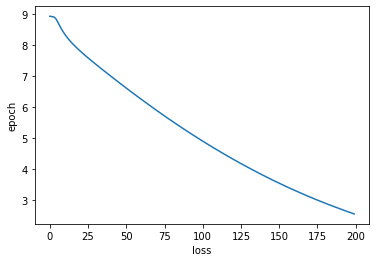

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(N_EPOCHS), train_losses)
ax.set_xlabel('loss')
ax.set_ylabel('epoch')